In [326]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
import pytorch_lightning as pl
import pandas as pd
from PIL import Image
from sklearn import metrics

In [3]:
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Define Model

In [311]:
class Classifier(pl.LightningModule):
    def __init__(self, pos_weight : torch.Tensor = torch.Tensor(1)):
        """
        Args:
            pos_weight (tensor): weighting of positive class loss to negative class loss
        """
        super(Classifier, self).__init__()
        self.model = models.resnet18(pretrained=False)
        # change 1st conv layer from 3 channel to 1 channel
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        #change to single output
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)
        self.pos_weight = pos_weight
        self.BCELoss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer
    
    def BCE_loss(self, logits, labels):
        return self.BCELoss(logits, labels.float())
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)   # we already defined forward and loss in the lightning module. We'll show the full code next
        logits = torch.flatten(logits)
        loss = self.BCE_loss(logits, y)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        logits = torch.flatten(logits)
        loss = self.BCE_loss(logits, y)
        self.log('val_loss', loss)
        
    def predict(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

In [312]:
class CXRDataset(Dataset):
    def __init__(self, excel_path : str = "./", img_dir : str = "./",
                 img_brt_std : float = 0.10448302):
        """
        Args:
            excel_path (string): Path to excel file with ids and labels.
            img_dir (string): Directory with all the png images.
            img_brt_std (float): Standard deviation of brightness of training dataset.
        """
        self.dataset = self.prepare_dataset(excel_path)
        self.img_dir = img_dir
        self.img_brt_std = img_brt_std
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=img_brt_std*2),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        
    def prepare_dataset(self, excel_path):
        df = pd.read_excel(excel_path)
        df = df.sort_values(by='Abnormal', ascending=False)
        df = df.drop_duplicates(subset="image_id", keep="first")
        df = df.sample(frac=1).reset_index(drop=True)
        return df
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataset['image_id'].iloc[idx] + '.png')
        image = Image.open(img_path)
        image = self.transform(image)
        label = self.dataset['Nodule/Mass'].iloc[idx]
        uuid = self.dataset['image_id'].iloc[idx]
        return image, label

In [313]:
class DataModule(pl.LightningDataModule):
    def __init__(self, img_dir: str = "./", train_file: str = "./",
                 val_file:str="./", batch_size: int = 24, num_workers: int = 0):
        """
        Args:
            img_dir (string): Directory with all the png images.
            train_file (string): path to train image excel
            val_file (string): path to validation image excel
            batch_size (int): batch size for training
        """
        super().__init__()
        self.img_dir = img_dir
        self.train_file = train_file
        self.val_file = val_file
        self.batch_size = batch_size
        self.num_workers = num_workers
    
    def prepare_data(self):
        self.train_data = CXRDataset(self.train_file, self.img_dir)
        self.val_data = CXRDataset(self.val_file, self.img_dir)
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size,
                         num_workers=self.num_workers)
        

## Train Model

In [314]:
dataset = DataModule('imgs/', './train.xlsx', './test.xlsx')
dataset.prepare_data()

In [317]:
num_pos = dataset.train_data.dataset['Nodule/Mass'].sum()
num_neg = len(dataset.train_data.dataset['Nodule/Mass']) - num_pos
pos_weight = torch.Tensor([num_neg / num_pos])

In [318]:
model = Classifier(pos_weight=pos_weight)

In [320]:
trainer = pl.Trainer(checkpoint_callback=True, max_epochs=14, logger=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [321]:
trainer.fit(model, dataset.train_dataloader(), dataset.val_dataloader())
trainer.save_checkpoint("models/node_improved_model_1.ckpt")


  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | BCELoss | BCEWithLogitsLoss | 0     
2 | sigmoid | Sigmoid           | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-gqmopi53/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  83%|████████▎ | 417/501 [26:23<05:18,  3.79s/it, loss=1.48, v_num=9] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|████████▎ | 418/501 [24:00<04:45,  3.44s/it, loss=1.19, v_num=9] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|████████▎ | 418/501 [24:05<04:46,  3.45s/it, loss=1.22, v_num=9] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|████████▎ | 418/501 [24:07<04:46,  3.45s/it, loss=1.13, v_num=9] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|████████▎ | 417/501 [40:31<08:08,  5.82s/it, loss=1.11, v_num=9] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  83%|████████▎ | 418/501 [25:26<05:02,  3.64s/it, loss=1.06, v_num=9] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  83%|████████▎ | 418/501 [25:35<05:04,  3.66s/it, loss=1.13, v_num=9] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  83%|████████▎ | 418/501 [25:40<05:05,  3.68s/it, loss=1.06, v_num=9] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  83%|████████▎ | 418/501 [25:29<05:02,  3.65s/it, loss=1.11, v_num=9] 
Validating: 0it [00:00, ?it/s]
E

In [369]:
trainer = pl.Trainer(resume_from_checkpoint='models/node_improved_model_1.ckpt',
                     checkpoint_callback=True, max_epochs=20, logger=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [370]:
trainer.fit(model, dataset.train_dataloader(), dataset.val_dataloader())
trainer.save_checkpoint("models/node_improved_model_1-adam-e20.ckpt")

Restoring states from the checkpoint file at models/node_improved_model_1.ckpt
Restored all states from the checkpoint file at models/node_improved_model_1.ckpt

  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | BCELoss | BCEWithLogitsLoss | 0     
2 | sigmoid | Sigmoid           | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 14:  83%|████████▎ | 417/501 [28:02<05:38,  4.03s/it, loss=1.05, v_num=13] 
Validating: 0it [00:00, ?it/s]
Epoch 15:  83%|████████▎ | 418/501 [28:07<05:34,  4.03s/it, loss=0.92, v_num=13] 
Validating: 0it [00:00, ?it/s]
Epoch 16:  83%|████████▎ | 417/501 [29:20<05:53,  4.21s/it, loss=0.952, v_num=13]
Validating: 0it [00:00, ?it/s]
Epoch 17:  83%|████████▎ | 417/501 [30:41<06:09,  4.40s/it, loss=0.897, v_num=13] 
Validating: 0it [00:00, ?it/s]
Epoch 18:  83%|████████▎ | 417/501 [31:29<06:19,  4.52s/it, loss=0.876, v_num=13] 
Validating: 0it [00:00, ?it/s]
Epoch 19:  83%|████████▎ | 417/501 [28:50<05:47,  4.14s/it, loss=0.993, v_num=13] 
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 501/501 [30:48<00:00,  3.68s/it, loss=0.993, v_num=13]


## Evaluate Model

In [327]:
def validate(model, val_loader):
    labels = []
    pred_list = []
    for x, y in val_loader:
        #x = x.to(device)
        preds = model.predict(x)
        labels += list(y.detach().cpu().numpy())
        pred_list += list(preds.detach().cpu().numpy())
    return labels, pred_list

def calc_auc(labels, pred_list):
    results = {}
    results['fpr'], results['tpr'], results['thresholds'] = metrics.roc_curve(labels, pred_list)
    results['auc'] = metrics.auc(results['fpr'], results['tpr'])
    return results

In [356]:
def analysis(labels, pred_list, threshold : float = 0.5):
    results = {}
    results['fpr'], results['tpr'], results['thresholds'] = metrics.roc_curve(labels, pred_list)
    results['auc'] = metrics.auc(results['fpr'], results['tpr'])
    
    pred_class_list = []
    for logit in pred_list:
        if logit >= threshold:
            pred_class = 1
        else:
            pred_class = 0
        pred_class_list.append(pred_class)
    
    prfs = metrics.precision_recall_fscore_support(labels, pred_class_list)
    results['precision'], results['recall'], results['fscore'], results['support'] = prfs
    
    results['confusion_matrix'] = metrics.confusion_matrix(labels, pred_class_list)
    
    return results

def plot_confusion_matrix(confusion_matrix):
    
    ax = plt.subplot()
    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Normal', 'Nodule/Mass']); ax.yaxis.set_ticklabels(['Normal', 'Nodule/Mass']);


EPOCH 20

In [371]:
labels, pred_list = validate(model, dataset.val_dataloader())

In [403]:
results = analysis(labels, pred_list, threshold=0.4)

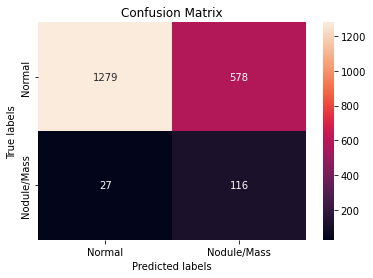

In [404]:
plot_confusion_matrix(results['confusion_matrix'])

In [406]:
np.save('evaluation/adam_fpr.npy', results['fpr'])
np.save('evaluation/adam_tpr.npy', results['tpr'])

In [390]:
results['auc']

0.8180462510026323

In [391]:
results['precision']

array([0.97932619, 0.16714697])

In [392]:
results['recall']

array([0.68874529, 0.81118881])

In [393]:
results['fscore']

array([0.80872589, 0.27718041])

In [394]:
results['support']

array([1857,  143])

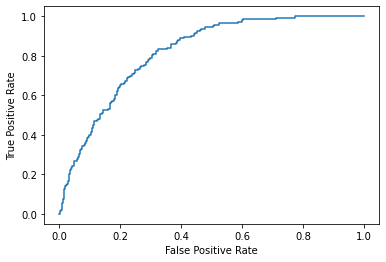

In [395]:
roc_curve = metrics.RocCurveDisplay(fpr=results['fpr'], tpr=results['tpr'])
roc_curve.plot()
plt.show()

EPOCH 14


In [328]:
labels, pred_list = validate(model, dataset.val_dataloader())

In [357]:
results = analysis(labels, pred_list)

In [405]:
results['auc']

0.8180462510026323

In [366]:
results['precision']

array([0.96685879, 0.15849673])

In [367]:
results['recall']

array([0.72267097, 0.67832168])

In [368]:
results['fscore']

array([0.82711864, 0.25695364])

In [363]:
results['support']

array([1857,  143])

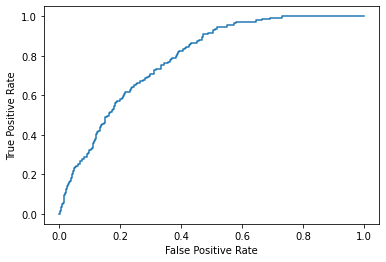

In [359]:
roc_curve = metrics.RocCurveDisplay(fpr=results['fpr'], tpr=results['tpr'])
roc_curve.plot()
plt.show()

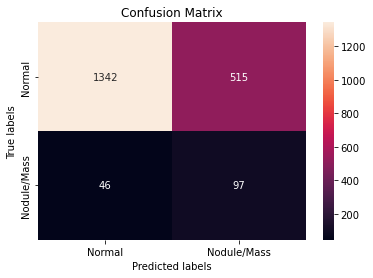

In [360]:
plot_confusion_matrix(results['confusion_matrix'])

In [292]:
print('All Negative Accuracy: ', 100 * (dataset.val_data.dataset.groupby(['Nodule/Mass']).
                                    count().iloc[0].values[0] / len(dataset.val_data.dataset)), '%')


All Negative Accuracy:  92.85 %


# Optimise

In [12]:
dataset.train_data.dataset.groupby(['Nodule/Mass', 'Abnormal']).count()

Unnamed: 0  image_id
Nodule/Mass Abnormal                      
0           0               7045      7045
            1               2418      2418
1           1                537       537

## Experiments

### Brightness

In [61]:
def get_brightness_means(img_dataset: DataModule):
    
    brightness_means = []
    for sample in img_dataset:
        img = sample[0]
        brightness_means.append(img.mean())
        
    return brightness_means

In [62]:
means = get_brightness_means(dataset.train_data)

<AxesSubplot:ylabel='Count'>

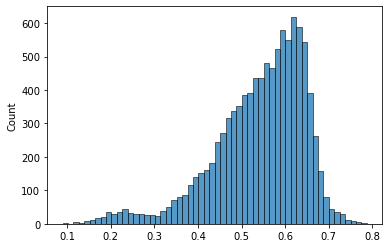

In [63]:
sns.histplot(np.array(means))

In [202]:
np.std(means)

0.10448302

In [66]:
np.mean(means)

0.5407106

In [247]:
img_num = 0

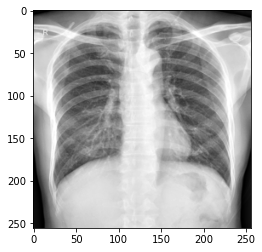

In [248]:
img_path = os.path.join('imgs/', dataset.train_data.dataset['image_id'].iloc[img_num] + '.png')
image = Image.open(img_path)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

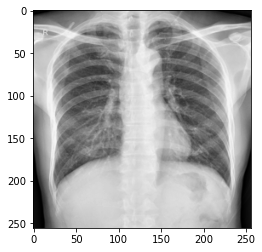

In [265]:
plt.imshow(dataset.train_data[img_num][0].squeeze(), cmap='gray', vmin=-1, vmax=1)

In [181]:
img_num += 1

## Evaluation

- ROC Curve.
- Thresholding Plot (histogram of prediction probability) compare Nodule/Mass label vs Normal label
- Threshold choice w/ consideration of business problem